### imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier



KeyboardInterrupt: 

In [937]:
from types import FunctionType
class DataManager():
    
    def __init__(self):
        self.transformations = {}
       
    
    def add_data_prep(self, func: FunctionType, name=None ,  version='1.0'):
        """functions should get (X_train, X) and return new X"""
        if not name:
            name = func.__name__
        self.transformations[version] = self.transformations.get(version, {})[name] = func
    
    def prep_all_data(self, X_train, X, version='1.0'):
        """returns new X"""
        for func in self.transformations[version].values:
            X = func(X_train,X)
        return X




# first glance

In [938]:
data = pd.read_csv('train.csv')
data.set_index('id')

Y = data.loc[:,'purchase'] 
X = data.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.8,random_state=23)

print('y value couns:\n',y_train.value_counts(), sep='')
del X, Y
X_train.head(5)


y value couns:
0    1768
1     327
Name: purchase, dtype: int64


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
2442,2442,0.0,0.000000,0.0,0.0 minutes,5.0,108.0 minutes,108.000000,0.000000,0.080000,...,May,2.0,chrome_90.1.7,3.0,Returning_Visitor,False,c_13,92.047040,log202,NaN
4138,4138,7.0,188.166667,0.0,0.0 minutes,52.0,1089.642857 minutes,1277.809524,0.003509,0.010234,...,May,2.0,browser_5_v19,6.0,Returning_Visitor,True,c_5,95.347227,log8080,NaN
8935,8935,7.0,133.466667,4.0,46.5 minutes,26.0,1357.833333 minutes,NaN,0.000000,0.018487,...,Nov,3.0,chrome_89,9.0,New_Visitor,True,c_2,87.950930,log202,NaN
3648,3648,4.0,259.000000,1.0,42.0 minutes,18.0,401.968254 minutes,NaN,0.000000,0.017105,...,May,1.0,safari_14,3.0,Returning_Visitor,False,c_3,109.345812,log404,NaN
10110,10110,1.0,153.500000,0.0,0.0 minutes,NaN,1002.847222 minutes,NaN,0.000000,0.009524,...,Nov,2.0,chrome_90.1.7,4.0,Returning_Visitor,False,c_2,117.950076,log200,NaN


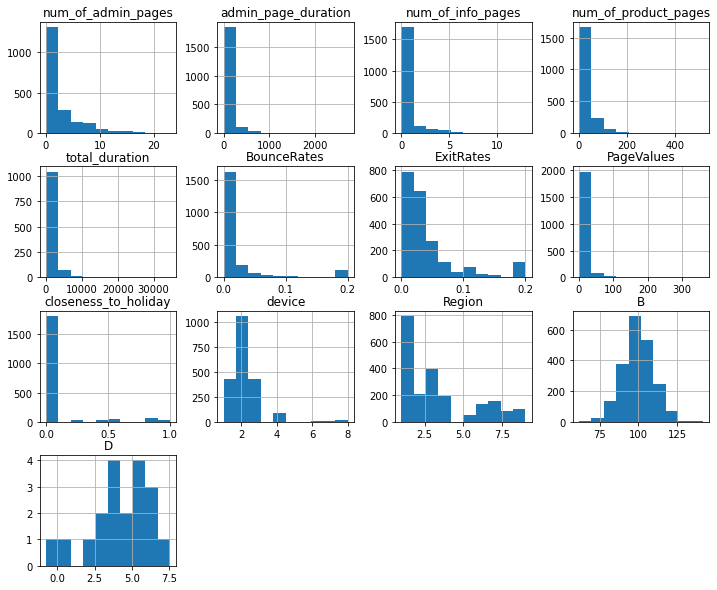

In [939]:
X_train.iloc[:,1:].hist(figsize=(12,10))
pass

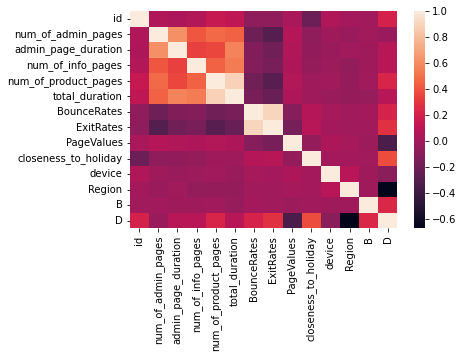

In [940]:
corr = X_train.corr()
sb.heatmap(corr)
pass

durations are linked

# exploration and preprocessing
1. Convert non-numeric features to numeric/dummy
2. Fill out missing values


In [941]:
print("** types: **")
print(X_train.dtypes)

print('\n** label values: **\n',y_train.value_counts())
print(f'purchased sessions are around {int((y_train.loc[y_train == 1].shape[0] / y_train.shape[0]) * 100)}% of all sessions')

** types: **
id                         int64
num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
dtype: object

** label values: **
 0    1768
1     327
Name: purchase, dtype: int64
purchased sessions are around 15% of all sessions


## id
id is probelbly usless for us

In [942]:
def id_prep(X):
    X = X.drop(columns=['id'])
    return X

X_test = id_prep(X_test)
X_train = id_prep(X_train)


### page durations

In [943]:
## convert to numeric
fields = ['info_page_duration', 'product_page_duration']

def page_durations_prep(X):
    for field in fields:
        print(field, 'str structure:', X[field].value_counts().index[0])

        # make sure all durations are in minutes
        print('not minutes count: ', len(X.loc[~X[field].str.contains('minutes').astype('bool'),(field)]))
        print('nan count: ', X[field].isnull().sum())

        # convert to float `type(d)==str ` handles nan values
        X[field] = [float(d.split()[0]) if type(d) is str else np.nan for d in X[field]]

        print('new types:')
        X.dtypes[fields]

    return X

print('train:')
X_train = page_durations_prep(X_train)
print('test:')
X_test = page_durations_prep(X_test)






train:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  58
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  136
new types:
test:
info_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  259
new types:
product_page_duration str structure: 0.0 minutes
not minutes count:  0
nan count:  485
new types:


In [944]:
## fill missing vlaues
avg_time_in_admin_page = (X_train.admin_page_duration / X_train.num_of_admin_pages).mean()
avg_time_in_info_page = (X_train.info_page_duration / X_train.num_of_info_pages).mean()
avg_time_in_product_page = (X_train.product_page_duration / X_train.num_of_product_pages).mean()

fields.append('admin_page_duration')
avgs = (avg_time_in_info_page, avg_time_in_product_page, avg_time_in_admin_page)

def page_durations_data_prep(X):
    for i, field in enumerate(fields):
        X[field] = X[field].fillna(avgs[i])
    return X

X_train = page_durations_data_prep(X_train)
X_test = page_durations_data_prep(X_test)



In [945]:
## total duration
computed_durations = X_train.admin_page_duration + X_train.info_page_duration + X_train.product_page_duration


def total_druation_data_prep(X):
    X.total_duration = X.total_duration.fillna(computed_durations)
    return X

X_train = total_druation_data_prep(X_train)
X_test = total_druation_data_prep(X_test)


### num of page visits

In [946]:
# fill missing values
fields = ('num_of_info_pages', 'num_of_product_pages' ,'num_of_admin_pages' )
avg_num_of_admin_pages = (X_train.admin_page_duration / avg_time_in_admin_page).mean()
avg_num_of_info_pages = (X_train.info_page_duration / avg_time_in_info_page).mean()
avg_num_of_product_pages = (X_train.product_page_duration / avg_time_in_product_page).mean()

avgs = (avg_num_of_info_pages, avg_num_of_product_pages, avg_num_of_admin_pages)

def num_of_visits_data_prep(X: pd.DataFrame):
    for i, field in enumerate(fields):
        X[field] = X[field].fillna(avgs[i])
    return X


X_train = num_of_visits_data_prep(X_train)
X_test = num_of_visits_data_prep(X_test)

### user type
user type has mainly two values, `New_Visitor` and  `Returning_Visitor`.
We wanted to see if we can map it to a binary feature.
For this, we:
1. made sure that `nan` and `other` are very rare
2. made sure there is no strong correlation between `other` and the label or featrue.

In [947]:
# check values
vc = X_train.user_type.value_counts()
nan_count = X_train.user_type.isnull().sum()
print('original user type values:\n', vc)
print('nan count        :', nan_count)
print('\n`other` categoryh is only ', f"{round(vc['Other'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('`Returning_Visitor` categoryh is ', f"{round(vc['Returning_Visitor'] / X_train.shape[0] * 100, 2)}%", 'of the data')
print('nan values are only ', f"{round(nan_count / X_train.shape[0] * 100, 2)}%", 'of the data')



original user type values:
 Returning_Visitor    1781
New_Visitor           290
Other                  17
Name: user_type, dtype: int64
nan count        : 7

`other` categoryh is only  0.81% of the data
`Returning_Visitor` categoryh is  85.01% of the data
nan values are only  0.33% of the data


explore correlations betwenn user type and other features

In [948]:
X_train_user_dummy = pd.get_dummies(X_train,columns=['user_type'],drop_first=False)

<AxesSubplot:>

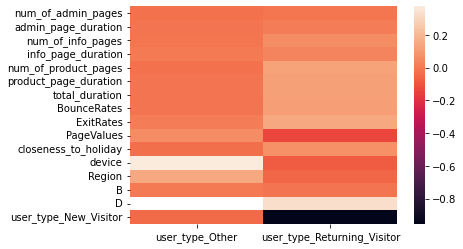

In [949]:
sb.heatmap(X_train_user_dummy.corr()[16:19].T[:16])

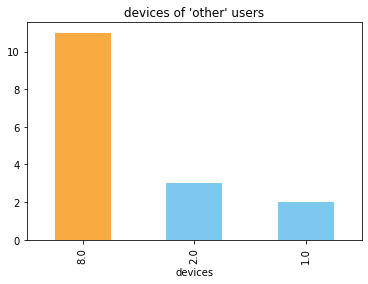

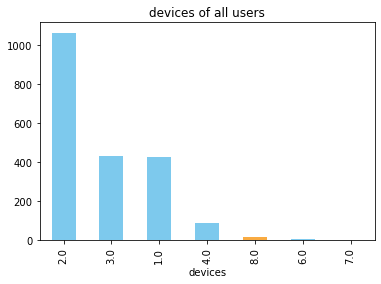

In [950]:

X_train.loc[X_train.user_type == 'Other', ('device')].value_counts().plot.bar(color=['#F9AB42']+['#7DC9ED']*2,
 title="devices of 'other' users", xlabel='devices')
plt.show()
devices_all = X_train.device.value_counts()
i = np.where(devices_all.index == 8.0)[0][0]
clrs = ['#7DC9ED']*7
clrs[i] = "#F9AB42"
devices_all.plot.bar(color=clrs,
 title="devices of all users", xlabel='devices')
plt.show()

### user_type - conclusion
two interesting correlartion here:  
a. `device` and `Other`:   
altough device 8 is very rare, almost all of device 8 sessions are `other`.  
It may mean that device 8 has some bug when collecing `user_type` data. However for our purpose it is not helpful (We were looking for a way to turn "other" to one of the other two.)  
b. `D`. but since `D` is mostly missing values, We shall treat `user type` as binary: only new users (0) and returing users (1)

In [951]:
#  map 'Returning_Visitor' , missing value and  'other' to 1, and New_Visitor to 0
RETURNING ='Returning_Visitor'

def user_type_data_prep(X):
    X.user_type = [1 if u_type == RETURNING else 0 for u_type in X.user_type] 
    return X

X_train = user_type_data_prep(X_train)
X_test = user_type_data_prep(X_test)




## D
d's seem to have mostly nan values
If it's lower than 10%, we will remove it altogether

In [952]:
valid_ds = X_train.loc[~np.isnan(X_train.D)]
print('only', str((valid_ds.shape[0] / X_train.shape[0]) * 100)[:3], "% of D's have values")

def d_data_prep(X):
    # remove D feature        
    return X.drop(columns=('D'))
del valid_ds

X_train = d_data_prep(X_train)
X_test = d_data_prep(X_test)


only 0.9 % of D's have values


## Bounce rate,  Exit rate, Page value

In [953]:
print('BounceRates nan count:', X_train.BounceRates.isnull().sum())
print('ExitRates nan count:', X_train.ExitRates.isnull().sum())
print('page values nan count:', X_train.PageValues.isnull().sum())

def rates_page_value_data_prep(X):
    global X_train
    # so little nan values - lets fill with mean
    X.BounceRates = X_train.BounceRates.fillna(X_train.BounceRates.mean())
    X.ExitRates = X_train.ExitRates.fillna(X_train.ExitRates.mean())
    X.PageValues = X_train.PageValues.fillna(X_train.PageValues.mean())
    return X

X_train = rates_page_value_data_prep(X_train)
X_test = rates_page_value_data_prep(X_test)


BounceRates nan count: 5
ExitRates nan count: 3
page values nan count: 6


## closeness to holiday

closeness_to_holiday nan caount: 85


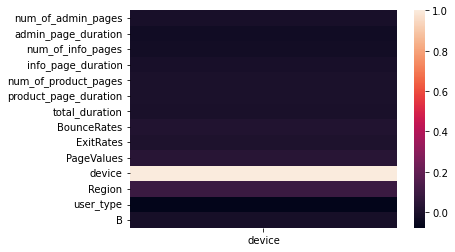

In [954]:
print('closeness_to_holiday nan caount:', X_train.closeness_to_holiday.isnull().sum())
corr = X_train.corr()
sb.heatmap(corr.iloc[11:12].T[corr.columns != 'closeness_to_holiday'])
pass



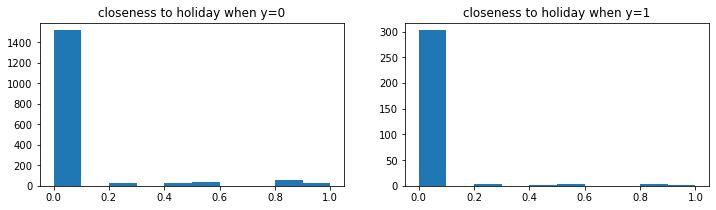

In [955]:

figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[y_train ==yi])
    axe.set_title(f'closeness to holiday when y={yi}')
plt.show()



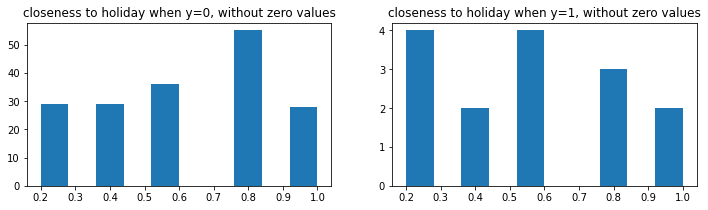

In [956]:
figure, axes = plt.subplots(1,2)
figure.set_size_inches((12,3))
for axe, yi in zip(axes, (0,1)):
    axe.hist(X_train.closeness_to_holiday[(y_train ==yi) & X_train.closeness_to_holiday != 0.0])
    axe.set_title(f'closeness to holiday when y={yi}, without zero values')
plt.show()


we didnt found any intersting correlataions, using mean

In [957]:
def closeness_data_prep(X):
    global X_train
    X.closeness_to_holiday = X_train.closeness_to_holiday.fillna(X_train.closeness_to_holiday.mean())
    return X

X_train = closeness_data_prep(X_train)
X_test = closeness_data_prep(X_test)


## Device

In [958]:
X_train.device.value_counts()


2.0    1063
3.0     432
1.0     424
4.0      84
8.0      14
6.0       2
7.0       1
Name: device, dtype: int64

In [959]:

mapper = {1.0: '1', 2.0: '2', 3.0: '3', 'Default': 'other'}
def make_dummy_device(X: pd.DataFrame):
    X.device = [mapper.get(d, mapper['Default']) for d in X.device]    
    return pd.get_dummies(data=X, columns=['device'], drop_first=False)
    
X_train = make_dummy_device(X_train)
X_test = make_dummy_device(X_test)

In [960]:
X_train.columns

Index(['num_of_admin_pages', 'admin_page_duration', 'num_of_info_pages',
       'info_page_duration', 'num_of_product_pages', 'product_page_duration',
       'total_duration', 'BounceRates', 'ExitRates', 'PageValues',
       'closeness_to_holiday', 'Month', 'internet_browser', 'Region',
       'user_type', 'Weekend', 'A', 'B', 'C', 'device_1', 'device_2',
       'device_3', 'device_other'],
      dtype='object')

In [961]:
X_train.C.value_counts()

log200     378
log404     363
log_100    357
log202     341
log8080    332
log400     320
Name: C, dtype: int64

In [962]:

def make_dummy_C(X: pd.DataFrame):
    def extract_num(s):   
        if s is np.nan:
             return s
        for indx, chr in enumerate(s):
            if str.isdigit(chr):
                break
        return s[indx:]
    X.C = [extract_num(c) for c in X.C]

    return pd.get_dummies(data=X, columns=['C'], drop_first=False)
    

X_train = make_dummy_C(X_train)
X_test = make_dummy_C(X_test)

## weekand

In [963]:
X_train.Weekend.value_counts()

False    1588
True      502
Name: Weekend, dtype: int64

In [964]:

def weekend_data_prep(X):
    X.Weekend = [1 if w else 0 for w in X.Weekend]
    return X

X_train = weekend_data_prep(X_train)
X_test = weekend_data_prep(X_test)
X_train.Weekend.value_counts()



0    1588
1     507
Name: Weekend, dtype: int64

## B

In [965]:
print("B nan count:", X_train.B.isnull().sum())
def b_data_prep(X):
    global X_train
    X.B = X.B.fillna(X_train.B.mean())
    return X

X_train = b_data_prep(X_train)
X_test = b_data_prep(X_test)

print("B nan count after filling - train:", X_train.B.isnull().sum())
print("B nan count after filling - test:", X_test.B.isnull().sum())




B nan count: 6
B nan count after filling - train: 0
B nan count after filling - test: 0


## browser

In [966]:
X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
X_train['internet_browser'] = X_train['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

X_test.internet_browser = X_test.internet_browser.str.replace('\d+', '')
X_test['internet_browser'] = X_test['internet_browser'].astype(str).str.extract(r'([A-Za-z]+(?: [A-Za-z]+)*)')

print(X_train.internet_browser.value_counts())

# corr = X_train.corr()
# sb.heatmap(corr.iloc[8:15].T[corr.columns != 'internet_browser'])


# X_train.internet_browser = ['Other' if i == 'nan' else X_train.internet_browser]


chrome     1286
safari      380
browser     192
nan         123
edge        114
Name: internet_browser, dtype: int64


/var/folders/rc/5_32pzd152x3trn7d63n2s6c0000gn/T/ipykernel_17869/1266507644.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  X_train.internet_browser = X_train.internet_browser.str.replace('\d+', '')
/var/folders/rc/5_32pzd152x3trn7d63n2s6c0000gn/T/ipykernel_17869/1266507644.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  X_test.internet_browser = X_test.internet_browser.str.replace('\d+', '')


In [967]:
X_train_browser_dummy = pd.get_dummies(X_train,columns=['internet_browser'],drop_first=False)

<AxesSubplot:>

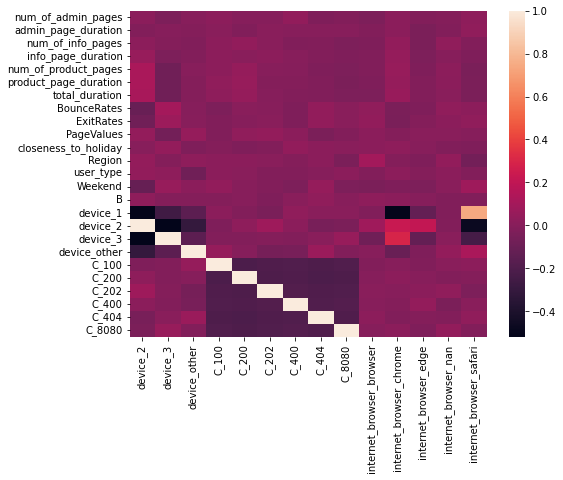

In [968]:
corr = X_train_browser_dummy.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr.iloc[16:].T[~corr.columns.str.startswith('internet_browser')])


In [969]:
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,device_1,device_2,device_3,device_other,C_100,C_200,C_202,C_400,C_404,C_8080
2442,0.0,0.000000,0.00000,0.00,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,...,0,1,0,0,0,0,1,0,0,0
4138,7.0,188.166667,0.00000,0.00,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,...,0,1,0,0,0,0,0,0,0,1
8935,7.0,133.466667,4.00000,46.50,26.000000,1357.833333,1537.800000,0.000000,0.018487,18.269401,...,0,0,1,0,0,0,1,0,0,0
3648,4.0,259.000000,1.00000,42.00,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,...,1,0,0,0,0,0,0,0,1,0
10110,1.0,153.500000,0.00000,0.00,30.986384,1002.847222,1156.347222,0.000000,0.009524,41.134331,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.0,0.000000,0.00000,0.00,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,...,0,1,0,0,0,1,0,0,0,0
9704,1.0,10.500000,3.00000,264.75,30.986384,38.050190,10320.007560,0.005025,0.023180,0.000000,...,0,1,0,0,0,0,0,0,0,1
10185,0.0,0.000000,0.00000,0.00,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,...,1,0,0,0,0,0,0,0,0,1
9256,7.0,104.450000,0.00000,0.00,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,...,1,0,0,0,0,0,0,0,1,0


### fill na - browser
we can see there's a link between device and browswer, device 1 linked to safari (probelbly iphone/mac?) and devices 2 and 3 linked to chrome.

In [970]:

def browser_data_prep(X: pd.DataFrame):
    global X_train
    X = pd.get_dummies(X,columns=['internet_browser'],drop_first=False)    


    # device 1 means safari
    X.loc[(X.internet_browser_nan == 1) & (X.device_1 > 0), ('internet_browser_safari',)] = 1

    # device 2/3 means chrome
    X.loc[(X.internet_browser_nan == 1) & (X.device_2 + X.device_3  > 0), ('internet_browser_chrome',)] = 1

    print(X.loc[(X.internet_browser_nan == 1) & (X.device_other == 1)].shape[0], ' nan values left. we shall fill it with chrome - chrome is the most common')

    # # fill with chrome
    X.loc[(X.internet_browser_nan == 1) & (X.device_other == 1), 'internet_browser_chrome'] = 1

    # make sure no nan left 
    print(X.loc[(X.internet_browser_nan == 1) & ((X.internet_browser_chrome + X.internet_browser_safari) < 1)].shape[0], ' nan values left.')

    # drop nan dummy
    return X.drop(columns=['internet_browser_nan'])

X_train = browser_data_prep(X_train)
X_test = browser_data_prep(X_test)

    

16  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.
42  nan values left. we shall fill it with chrome - chrome is the most common
0  nan values left.


## month
divide to 4 yearly quarters

In [971]:
Month = {'JAN':1, 'Feb':1, 'Mar':1, 'APR':2, 'May':2, 'June':2, 'Jul':3, 'Aug':3, 'Sep':3, 'Oct':4, 'Nov':4, 'Dec':4}
def month_data_prep(X):
     X.Month = X.Month.map(Month)
     X.Month = X.Month.fillna(X_train.Month.median())
     return X

X_train = month_data_prep(X_train)
X_test = month_data_prep(X_test)
X_train.Month.value_counts()


4.0    895
2.0    621
1.0    338
3.0    241
Name: Month, dtype: int64

## Region

In [972]:
print(X_train.Region.value_counts())
print('nan count before:', X_train.Region.isnull().sum())

# fill nan with median
def region_data_prep(X_t, X: pd.DataFrame):
    train_median = np.median(X_t.Region[~X_t.Region.isnull()])
    X.Region = X.Region.fillna(train_median)
    return X

c = X_train.copy()
c = region_data_prep(X_train, c)
X_train = region_data_prep(X_train, X_train)
X_test = region_data_prep(X_train, X_test)

print('nan count after:', X_train.Region.isnull().sum())



1.0    795
3.0    398
2.0    205
4.0    189
7.0    155
6.0    131
9.0     96
8.0     76
5.0     48
Name: Region, dtype: int64
nan count before: 2
nan count after: 0


## A feature

In [973]:
t1 = X_train.A[[str(a).split('_').__len__() == 2 for a in X_train.A]]
t2 = X_train.A[[str(a).split('_').__len__() > 2 for a in X_train.A]]
print('type 1:',t1.iloc[0:5])
print('count', t1.shape[0])

print('\ntype 2:\n', t2.iloc[0:5])
print('count', t2.shape[0])


type 1: 2442     c_13
4138      c_5
8935      c_2
3648      c_3
10110     c_2
Name: A, dtype: object
count 1915

type 2:
 3969    c_20_74
4926    c_20_14
4351    c_20_61
5329    c_20_47
5213     c_20_4
Name: A, dtype: object
count 34


In [974]:
print('type 1 describe:')
pd.Series([float(str(a).split('_')[1]) if str(a).split('_').__len__() == 2 else np.nan for a in X_train.A]).describe()


type 1 describe:


count    1915.000000
mean        3.800522
std         3.485887
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        19.000000
dtype: float64

since max is now 19, seems reasonble to use the `c_xx_??` type as `xx`  
this way we can transfer all using `.split('_')[1]`

<AxesSubplot:>

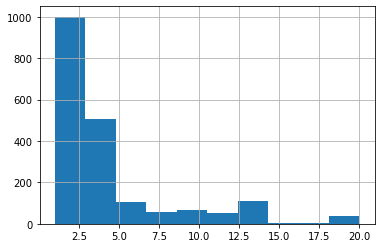

In [975]:
X_train.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_train.A]
X_test.A = [np.nan if a is np.nan else float(str(a).split('_')[1]) for a in X_test.A]

X_train.A.hist()


In [976]:
print('nan count:', X_train.A.isna().sum())

nan count: 146


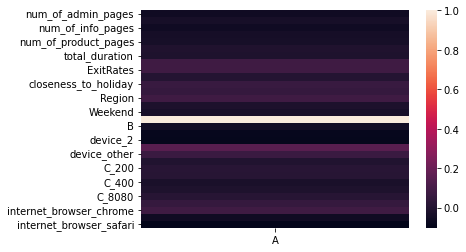

In [977]:
corr = X_train.corr()
sb.heatmap(corr[corr.columns == 'A'].T)
pass

since the distribution decreases left to rihgt - we will fill na with median.

nan count after filling - train: 0
nan count after filling - test: 0


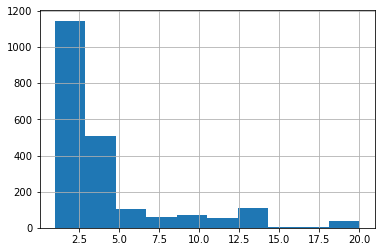

In [978]:
def a_data_prep(X_t, X):
    train_median = np.median(X_t.A[~X_t.A.isnull()])
    X.A = X.A.fillna(train_median)
    #X.A[X.A.isnull()] = train_median
    return X

X_train = a_data_prep(X_train, X_train)
X_test = a_data_prep(X_train, X_test)

X_train.A.hist()

print('nan count after filling - train:', X_train.A.isnull().sum())
print('nan count after filling - test:', X_test.A.isnull().sum())


In [980]:
X_test.A

8599      2.0
4646     13.0
5836      5.0
2476      6.0
8509     13.0
         ... 
8127      2.0
5478      3.0
5310     13.0
2254      1.0
10429     7.0
Name: A, Length: 8384, dtype: float64

# Outlier removal and normalization

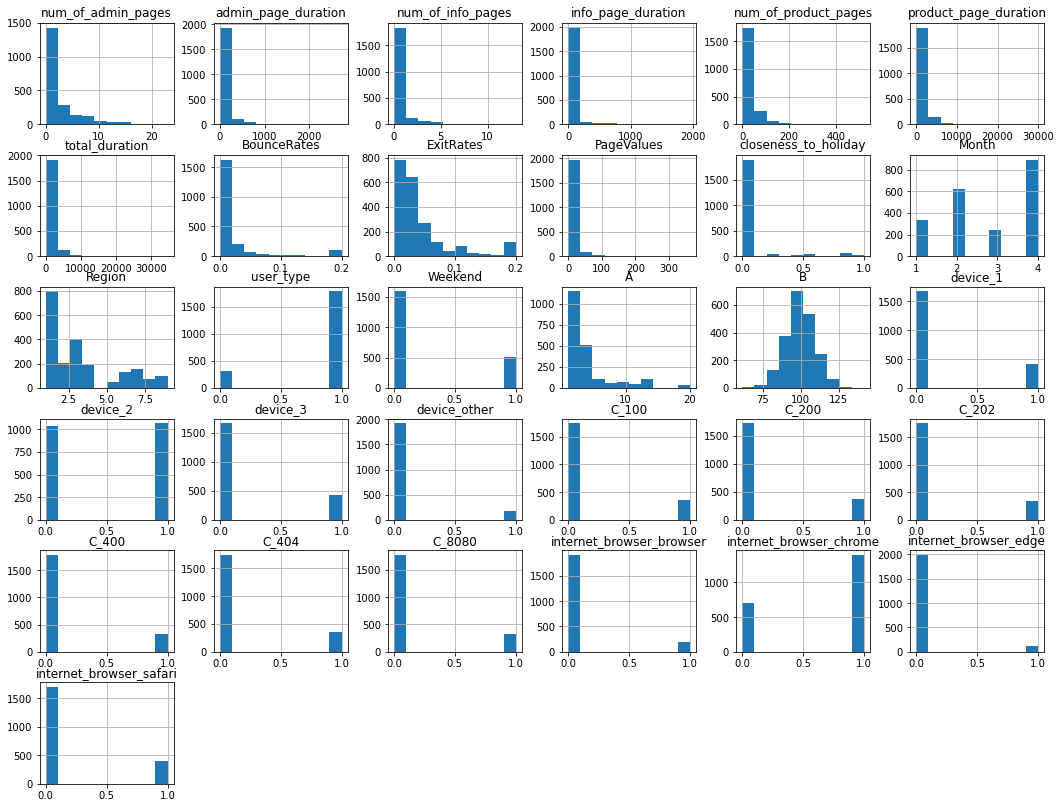

In [982]:
X_train.hist(figsize=(18,14))

pass

In [983]:
des = X_train.describe()
std = des.loc[des.index == 'std']
std.iloc[:,0:20]


,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,Region,user_type,Weekend,A,B,device_1,device_2,device_3
std,3.425202,180.54421,1.191541,138.033195,44.799489,2016.900234,2169.22172,0.046948,0.047094,22.738759,0.196322,1.154465,2.460814,0.35704,0.428399,3.94651,9.93346,0.401875,0.500065,0.404676


In [984]:
std.iloc[:,20:]


,device_other,C_100,C_200,C_202,C_400,C_404,C_8080,internet_browser_browser,internet_browser_chrome,internet_browser_edge,internet_browser_safari
std,0.277468,0.376079,0.384637,0.369242,0.359827,0.378571,0.365271,0.288596,0.47296,0.226889,0.393503


In [985]:
del std, des 

In [986]:
duration_treshold = 30
print("users who purchesed after less then 30 seconds:", y_train[X_train['total_duration'] < duration_treshold].sum())
print(f'number of users under {duration_treshold} seconds:', X_train.loc[X_train['total_duration'] < duration_treshold].shape[0])

users who purchesed after less then 30 seconds: 1
number of users under 30 seconds: 161


In [987]:
X_train

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_100,C_200,C_202,C_400,C_404,C_8080,internet_browser_browser,internet_browser_chrome,internet_browser_edge,internet_browser_safari
2442,0.0,0.000000,0.00000,0.00,5.000000,108.000000,108.000000,0.000000,0.080000,0.000000,...,0,0,1,0,0,0,0,1,0,0
4138,7.0,188.166667,0.00000,0.00,52.000000,1089.642857,1277.809524,0.003509,0.010234,20.117930,...,0,0,0,0,0,1,1,0,0,0
8935,7.0,133.466667,4.00000,46.50,26.000000,1357.833333,1537.800000,0.000000,0.018487,18.269401,...,0,0,1,0,0,0,0,1,0,0
3648,4.0,259.000000,1.00000,42.00,18.000000,401.968254,702.968254,0.000000,0.017105,0.000000,...,0,0,0,0,1,0,0,0,0,1
10110,1.0,153.500000,0.00000,0.00,30.986384,1002.847222,1156.347222,0.000000,0.009524,41.134331,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,0.0,0.000000,0.00000,0.00,2.000000,12.000000,12.000000,0.000000,0.100000,0.000000,...,0,1,0,0,0,0,1,0,0,0
9704,1.0,10.500000,3.00000,264.75,30.986384,38.050190,10320.007560,0.005025,0.023180,0.000000,...,0,0,0,0,0,1,0,1,0,0
10185,0.0,0.000000,0.00000,0.00,9.000000,891.500000,891.500000,0.000000,0.012500,0.000000,...,0,0,0,0,0,1,0,0,0,1
9256,7.0,104.450000,0.00000,0.00,63.000000,1242.661699,1347.111699,0.011912,0.026918,0.000000,...,0,0,0,0,1,0,0,0,0,1


### standarization

In [988]:
def standarization(X):
    standard_scaler = StandardScaler()
    standard_scaler.fit(X_train)
    X.loc[:,:] = standard_scaler.transform(X)
    return X 

X_train = standarization(X_train)
X_test = standarization(X_test)


In [989]:
X_train



,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_100,C_200,C_202,C_400,C_404,C_8080,internet_browser_browser,internet_browser_chrome,internet_browser_edge,internet_browser_safari
2442,-0.700113,-0.450067,-0.419041,-0.261708,-0.610362,-0.531158,-0.566718,-0.451502,0.808881,-0.291222,...,-0.45322,-0.469203,2.267972,-0.424596,-0.457804,-0.433953,-0.317637,0.713699,-0.239889,-0.486537
4138,1.344050,0.592402,-0.419041,-0.261708,0.439007,-0.044334,-0.027314,-0.376748,-0.672898,0.593731,...,-0.45322,-0.469203,-0.440923,-0.424596,-0.457804,2.304396,3.148247,-1.401151,-0.239889,-0.486537
8935,1.344050,0.289356,2.938758,0.075248,-0.141495,0.088670,0.092569,-0.451502,-0.497600,0.512417,...,-0.45322,-0.469203,2.267972,-0.424596,-0.457804,-0.433953,-0.317637,0.713699,-0.239889,-0.486537
3648,0.467980,0.984828,0.420409,0.042639,-0.320111,-0.385371,-0.292376,-0.451502,-0.526955,-0.291222,...,-0.45322,-0.469203,-0.440923,-0.424596,2.184342,-0.433953,-0.317637,-1.401151,-0.239889,2.055344
10110,-0.408090,0.400344,-0.419041,-0.261708,-0.030164,-0.087378,-0.083320,-0.451502,-0.687980,1.518206,...,-0.45322,2.131274,-0.440923,-0.424596,-0.457804,-0.433953,-0.317637,0.713699,-0.239889,-0.486537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6175,-0.700113,-0.450067,-0.419041,-0.261708,-0.677343,-0.578768,-0.610985,-0.451502,1.233666,-0.291222,...,-0.45322,2.131274,-0.440923,-0.424596,-0.457804,-0.433953,3.148247,-1.401151,-0.239889,-0.486537
9704,-0.408090,-0.391895,2.099308,1.656767,-0.030164,-0.565849,4.142088,-0.344442,-0.397928,-0.291222,...,-0.45322,-0.469203,-0.440923,-0.424596,-0.457804,2.304396,-0.317637,0.713699,-0.239889,-0.486537
10185,-0.700113,-0.450067,-0.419041,-0.261708,-0.521054,-0.142598,-0.205443,-0.451502,-0.624768,-0.291222,...,-0.45322,-0.469203,-0.440923,-0.424596,-0.457804,2.304396,-0.317637,-1.401151,-0.239889,2.055344
9256,1.344050,0.128600,-0.419041,-0.261708,0.684604,0.031553,0.004642,-0.197721,-0.318540,-0.291222,...,-0.45322,-0.469203,-0.440923,-0.424596,2.184342,-0.433953,-0.317637,-1.401151,-0.239889,2.055344


In [991]:
X_test

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,C_100,C_200,C_202,C_400,C_404,C_8080,internet_browser_browser,internet_browser_chrome,internet_browser_edge,internet_browser_safari
8599,4.000000e+00,9.375000e+01,6.783224e-17,1.102274e-17,70.000000,2161.388889,2255.138889,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,5.596160e-17,1.000000e+00,0.0,6.783224e-18,1.136190e-16,2.374128e-17,1.000000e+00
4646,3.000000e+00,1.526000e+02,6.783224e-17,1.102274e-17,28.000000,608.883333,761.483333,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.000000e+00,5.596160e-17,5.935321e-17,0.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17
5836,4.000000e+00,1.518000e+02,6.783224e-17,1.102274e-17,10.000000,265.400000,417.200000,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,5.596160e-17,1.000000e+00,0.0,6.783224e-18,1.136190e-16,2.374128e-17,1.000000e+00
2476,-1.611016e-17,-2.628499e-17,6.783224e-17,1.102274e-17,30.986384,90.666667,NaN,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,5.596160e-17,5.935321e-17,1.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17
8509,-1.611016e-17,-2.628499e-17,6.783224e-17,1.102274e-17,42.000000,2872.125000,NaN,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,1.000000e+00,5.935321e-17,0.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8127,3.000000e+00,2.240000e+02,2.000000e+00,4.200000e+01,132.000000,5098.754980,NaN,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,1.000000e+00,5.935321e-17,0.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17
5478,1.100000e+01,3.855667e+02,6.783224e-17,1.102274e-17,54.000000,1256.293333,1641.860000,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,1.000000e+00,5.935321e-17,0.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17
5310,8.000000e+00,1.260000e+02,1.000000e+00,1.340000e+01,13.000000,217.716667,357.116667,NaN,NaN,NaN,...,2.713290e-17,-3.391612e-17,1.611016e-17,5.596160e-17,1.000000e+00,0.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17
2254,-1.611016e-17,-2.628499e-17,6.783224e-17,1.102274e-17,30.986384,1076.977778,1076.977778,NaN,NaN,NaN,...,1.000000e+00,-3.391612e-17,1.611016e-17,5.596160e-17,5.935321e-17,0.0,6.783224e-18,1.000000e+00,2.374128e-17,-2.204548e-17


In [ ]:
X_train.num_of_admin_pages.isnull().sum()

0

In [ ]:
model = LogisticRegression(C=10)

model.fit(X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
auc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
auc


0.8824411557142264

In [ ]:
# train
#Cs = [1,10,100,500,1000]
Cs = [1,1000]

for c in Cs:
    log_reg =  LogisticRegression(C=c)
    log_reg.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_train, log_reg.predict_proba(X_train)[:,1])
    auc = roc_auc_score(y_train, log_reg.predict_proba(X_train)[:,1])
    print('C = ', c)
    print('AUC = ', auc)
    print('\n')
    
"""
    # plot
    plt.figure(figsize=(8,8))
    log_a,log_b = -log_reg.intercept_/log_reg.coef_[0][1], -log_reg.intercept_/log_reg.coef_[0][0]
    #plt.plot([im[0] for im in X_train_pro_5],[im[1] for im in X_train_pro_5],'ro',label='5', markeredgecolor='black', markeredgewidth=1)
    #plt.plot([im[0] for im in X_train_pro_1],[im[1] for im in X_train_pro_1],'bx',label='1')
    #plt.plot([0,b],[a,0],'black',label='linear_regression')
    plt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')
    #plt.ylim(0.4,1) # since there arent any sample with lower symmetry
    #plt.xlim(0,0.6) # since there arent any sample with higher Intensity
    plt.xlabel('Intensity')
    plt.ylabel('Symmetry')
    plt.title(f'c = {c}')

    plt.legend(numpoints=1)#handles=[red_dot, blue_x])
    plt.show()
"""

"""
log_reg =  LogisticRegression(C=1).fit(X_train, y_train)
plt.figure(figsize=(8,8))
log_a,log_b = -log_reg.intercept_/log_reg.coef_[0][1], -log_reg.intercept_/log_reg.coef_[0][0]
plt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')
plt.legend(numpoints=1)#handles=[red_dot, blue_x])
plt.show()

log_reg =  LogisticRegression(C=1000).fit(X_train, y_train)
plt.figure(figsize=(8,8))
log_a,log_b = -log_reg.intercept_/log_reg.coef_[0][1], -log_reg.intercept_/log_reg.coef_[0][0]
plt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')
plt.legend(numpoints=1)#handles=[red_dot, blue_x])
plt.show()

"""


C =  1
AUC =  0.8826106660024631
Intercept:  [-2.24802942]
Coefficients:  [ 0.02666605 -0.20432038  0.02015548  0.00302966  0.04818822  0.34442251
 -0.0742722  -0.03904703 -0.96776693  1.46074958 -0.06410793  0.36244351
 -0.07429561 -0.09777322 -0.0138129  -0.01670463 -0.16336996 -0.06545827
  0.08139031  0.04814005 -0.12208784  0.01550226  0.09468205  0.13144125
  0.06025737  0.17433984  0.04470881  0.05425777 -0.07582029  0.0635019
  0.0147228 ]


C =  1000
AUC =  0.882470560560145
Intercept:  [-2.26240086]
Coefficients:  [ 0.02449725 -0.20076445  0.02123439  0.00807877  0.04210574  0.42584415
 -0.15631997  0.02521561 -1.03178324  1.47629596 -0.06435978  0.36634071
 -0.07573974 -0.09715286 -0.01369427 -0.0169762  -0.16528399 -0.06619352
  0.08193624  0.04727191 -0.1207407   1.53116163  1.64526093  1.62058457
  1.51050897  1.70191894  1.51706245  0.05521681 -0.07656699  0.0652247
  0.01392357]




"\nlog_reg =  LogisticRegression(C=1).fit(X_train, y_train)\nplt.figure(figsize=(8,8))\nlog_a,log_b = -log_reg.intercept_/log_reg.coef_[0][1], -log_reg.intercept_/log_reg.coef_[0][0]\nplt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')\nplt.legend(numpoints=1)#handles=[red_dot, blue_x])\nplt.show()\n\nlog_reg =  LogisticRegression(C=1000).fit(X_train, y_train)\nplt.figure(figsize=(8,8))\nlog_a,log_b = -log_reg.intercept_/log_reg.coef_[0][1], -log_reg.intercept_/log_reg.coef_[0][0]\nplt.plot([0,log_b],[log_a,0],'purple',label='logistic_regression')\nplt.legend(numpoints=1)#handles=[red_dot, blue_x])\nplt.show()\n\n"

## Naïve Bayes Classifier 

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)


fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
auc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
auc

# Multi-Layer Perceptron

In [1]:
model = MLPClassifier(hidden_layer_sizes=(25,), max_iter=225, solver='sgd',verbose=False,
                        tol=10**-4,random_state=34, learning_rate_init=0.001, alpha=10)
model.fit(X_train, y_train)
score = model.score(X=X_train, y=y_train)


NameError: name 'MLPClassifier' is not defined